In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
#membaca data
data = pd.read_csv('dataset.csv')
data.head(10)

,Title,Text,Label
0,Suara Adzan Di Masjid Dapat Mengecilkan Virus...,Unggahan video tentang suara azan dapat melema...,Hoax
1,Viral Umpan Sensasional Arnold Saat Liverpool ...,Dua umpan sensasional bek kanan Liverpool Tren...,Valid
2,Penemu Vaksin AstraZeneca: Pandemi Berikutnya ...,Pengembang utama vaksin virus Corona (COVID-19...,Valid
3,Video Air Rebusan Belimbing Wuluh Dapat Mence...,Informasi yang salah. Belum ada penelitian yan...,Hoax
4,Akibat Bermain Hp POM Bensin Sambiroto Terbak...,Beberapa akun facebook mengunggah video yang d...,Hoax
5,Alasan Pemerintah Batal Terapkan PPKM Level 3 ...,Alasan pemerintah batal terapkan PPKM Level 3 ...,Valid
6,Dosen Kedokteran Gigi UI Meninggal Karena COV...,Tidak ada dosen dari Fakultas Kedokteran Gigi ...,Hoax
7,Minum Air Kelapa Sebagai Penangkal Racun Usai...,Klaim yang salah. Vaksin tidak mengandung racu...,Hoax
8,Daftar Kandungan Bahan Kimia Berbahaya dalam ...,Hal tersebut tidak benar. Kandungan aluminium ...,Hoax
9,Polisi Selidiki Viral Penumpang Mobil Meningga...,Viral di media sosial video dengan narasi penu...,Valid


In [3]:
#info type data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   4800 non-null   object
 1   Text    4800 non-null   object
 2   Label   4800 non-null   object
dtypes: object(3)
memory usage: 112.6+ KB


In [4]:
data.describe()

,Title,Text,Label
count,4800,4800,4800
unique,4588,4616,2
top,Nomor IMEI di Ponsel Bisa Disadap Polisi,Masyarakat\nTiban dikejutkan dengan viralnya ...,Valid
freq,2,2,2400


<AxesSubplot:xlabel='Label', ylabel='count'>

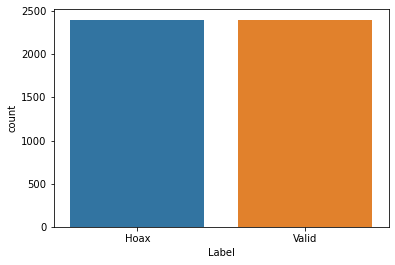

In [5]:
#value label
sns.countplot(data['Label'])

In [6]:
# menggabungan teks judul dan isi berita
data['Combined'] = data['Title'] + ' ' + data['Text']

In [7]:
#contoh data yang sudah di combine
for i in data.loc[8][['Title', 'Text','Combined']]:
    print(i,'\n')

 Daftar Kandungan Bahan Kimia Berbahaya dalam Vaksin Covid-19 

Hal tersebut tidak benar. Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam. Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi, sehingga aman digunakan untuk program vaksinasi.  â€œDownload file ini sebelum di delete websitenya? Dari hasil tes Vaksin, bahan kimia berbahaya yang terdapat dalam Vaksin : mata kuning juga bisa menjadi pertanda liver rusak akibat kemasukan cacing parasit kedalam liver dll.â€  Beredar sebuah narasi melalui pesan Whatsapp yang menunjukkan suatu daftar yang diklaim merupakan kandungan vaksin Covid-19. Setelah melakukan penelusuran, hal tersebut tidak benar. Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam. Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi, sehingga aman digunakan untuk program vaksinasi. Selain itu, ahli vaksin yang berspesialisasi dalam bidang epidemiologi pneumokokus, 

## Preprocessing

## Cleaning Data

In [8]:
#membersihkan data
def cleaning(text):
    #remove url
    text = re.sub(r"http\S+", "", str(text))
    #remove hex characters
    text = re.sub(r'(\\x(.){2})', '', text)
    #menghapus spasi awal teks
    text = text.lstrip()
    #remove newlines
    text = re.sub(r'\s+|\\n', ' ', text)
    #remove hashtags
    text = re.sub(r'\B#\w*[a-zA-Z]+\w*','', text)
    #remove single char
    text = re.sub(r'\b[a-zA-Z]\b','', text)
    #remove number
    text = re.sub(r'\d+','', text)
    #remove punctuation / tanda baca
    text = re.sub(r'[^\w\s]+', ' ', text)
    #remove spasi dari awal teks
    text = re.sub(r"/^\\s+/m", '', text)
    #remove character yang memilliki kurang dari 4 huruf
    text = re.sub(r'\b\w{1,3}\b', '', text)
    #remove spasi berlebih
    text = re.sub(r'\s+', ' ', text)
    #remove non-ascii character
    text = re.sub('[^\x00-\x7F]+', '', text)
    return text

data['Cleaning'] = data['Combined'].apply(cleaning)

In [9]:
#contoh data yang sudah dibersihkan
for i in data.loc[8][['Combined','Cleaning']]:
    print(i,'\n')

 Daftar Kandungan Bahan Kimia Berbahaya dalam Vaksin Covid-19 Hal tersebut tidak benar. Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam. Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi, sehingga aman digunakan untuk program vaksinasi.  â€œDownload file ini sebelum di delete websitenya? Dari hasil tes Vaksin, bahan kimia berbahaya yang terdapat dalam Vaksin : mata kuning juga bisa menjadi pertanda liver rusak akibat kemasukan cacing parasit kedalam liver dll.â€  Beredar sebuah narasi melalui pesan Whatsapp yang menunjukkan suatu daftar yang diklaim merupakan kandungan vaksin Covid-19. Setelah melakukan penelusuran, hal tersebut tidak benar. Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam. Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi, sehingga aman digunakan untuk program vaksinasi. Selain itu, ahli vaksin yang berspesialisasi dalam bidang epidemiologi pneumokokus, ya

### Case Folding

In [10]:
#mengubah huruf kapital menjadi huruf kecil
data['Case Folding'] = data['Cleaning'].str.lower()

In [11]:
#contoh data yang sudah di casefolding
for i in data.loc[8][['Cleaning','Case Folding']]:
    print(i,'\n')

Daftar Kandungan Bahan Kimia Berbahaya dalam Vaksin Covid tersebut tidak benar Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi sehingga aman digunakan untuk program vaksinasi Download file sebelum delete websitenya Dari hasil Vaksin bahan kimia berbahaya yang terdapat dalam Vaksin mata kuning juga bisa menjadi pertanda liver rusak akibat kemasukan cacing parasit kedalam liver Beredar sebuah narasi melalui pesan Whatsapp yang menunjukkan suatu daftar yang diklaim merupakan kandungan vaksin Covid Setelah melakukan penelusuran tersebut tidak benar Kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam Hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi sehingga aman digunakan untuk program vaksinasi Selain ahli vaksin yang berspesialisasi dalam bidang epidemiologi pneumokokus yakni Katherine Brien mengatakan bahwa vaksin Covid yang bere

### Tokenizing

In [12]:
#memisahkan kalimat menjadi potongan kata dengan menggunakan library word_tokenize dari nltk
data['Tokenized'] = data['Case Folding'].apply(word_tokenize)

In [13]:
for i in data.loc[8][['Case Folding','Tokenized']]:
    print(i,'\n')

daftar kandungan bahan kimia berbahaya dalam vaksin covid tersebut tidak benar kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi sehingga aman digunakan untuk program vaksinasi download file sebelum delete websitenya dari hasil vaksin bahan kimia berbahaya yang terdapat dalam vaksin mata kuning juga bisa menjadi pertanda liver rusak akibat kemasukan cacing parasit kedalam liver beredar sebuah narasi melalui pesan whatsapp yang menunjukkan suatu daftar yang diklaim merupakan kandungan vaksin covid setelah melakukan penelusuran tersebut tidak benar kandungan aluminium memang terdapat dalam kandungan vaksin dalam bentuk garam hanya saja kandungan garam aluminium tersebut sudah memenuhi standar farmasi sehingga aman digunakan untuk program vaksinasi selain ahli vaksin yang berspesialisasi dalam bidang epidemiologi pneumokokus yakni katherine brien mengatakan bahwa vaksin covid yang bere

### Normalisasi

In [14]:
#membaca data dan mengubahnya menjadi dictionary
file = open("combined_slang_words.txt", "r")

contents = file.read()
kamus = ast.literal_eval(contents)
file.close()
print(type(kamus))
kamus

<class 'dict'>


{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [15]:
## Change word

def normalisasi(text):
    final_string = ' '.join(str(kamus.get(word, word)) for word in text).split()
    return final_string

data['Normalisasi'] = data['Tokenized'].apply(normalisasi)

In [16]:
for i in data.loc[8][['Tokenized','Normalisasi']]:
    print(i,'\n')

['daftar', 'kandungan', 'bahan', 'kimia', 'berbahaya', 'dalam', 'vaksin', 'covid', 'tersebut', 'tidak', 'benar', 'kandungan', 'aluminium', 'memang', 'terdapat', 'dalam', 'kandungan', 'vaksin', 'dalam', 'bentuk', 'garam', 'hanya', 'saja', 'kandungan', 'garam', 'aluminium', 'tersebut', 'sudah', 'memenuhi', 'standar', 'farmasi', 'sehingga', 'aman', 'digunakan', 'untuk', 'program', 'vaksinasi', 'download', 'file', 'sebelum', 'delete', 'websitenya', 'dari', 'hasil', 'vaksin', 'bahan', 'kimia', 'berbahaya', 'yang', 'terdapat', 'dalam', 'vaksin', 'mata', 'kuning', 'juga', 'bisa', 'menjadi', 'pertanda', 'liver', 'rusak', 'akibat', 'kemasukan', 'cacing', 'parasit', 'kedalam', 'liver', 'beredar', 'sebuah', 'narasi', 'melalui', 'pesan', 'whatsapp', 'yang', 'menunjukkan', 'suatu', 'daftar', 'yang', 'diklaim', 'merupakan', 'kandungan', 'vaksin', 'covid', 'setelah', 'melakukan', 'penelusuran', 'tersebut', 'tidak', 'benar', 'kandungan', 'aluminium', 'memang', 'terdapat', 'dalam', 'kandungan', 'vaksin

### Stopwords Removal

In [17]:
#menghapus kata yang kurang penting, namun sering muncul (stopword) seperti kata penghubung
#mengambil stopword dari library python sastrawi
listStopword = set(stopwords.words('indonesian'))
listStopword.update(set(stopwords.words('english')))

def stopwords_removal(words):
    return [word for word in words if word not in listStopword]

data['Removed Stopwords'] = data['Normalisasi'].apply(stopwords_removal)

In [18]:
for i in data.loc[8][['Normalisasi','Removed Stopwords']]:
    print(i,'\n')

['daftar', 'kandungan', 'bahan', 'kimia', 'berbahaya', 'dalam', 'vaksin', 'covid', 'tersebut', 'tidak', 'benar', 'kandungan', 'aluminium', 'memang', 'terdapat', 'dalam', 'kandungan', 'vaksin', 'dalam', 'bentuk', 'garam', 'hanya', 'saja', 'kandungan', 'garam', 'aluminium', 'tersebut', 'sudah', 'memenuhi', 'standar', 'farmasi', 'sehingga', 'aman', 'digunakan', 'untuk', 'program', 'vaksinasi', 'download', 'file', 'sebelum', 'delete', 'websitenya', 'dari', 'hasil', 'vaksin', 'bahan', 'kimia', 'berbahaya', 'yang', 'terdapat', 'dalam', 'vaksin', 'mata', 'kuning', 'juga', 'bisa', 'menjadi', 'pertanda', 'liver', 'rusak', 'akibat', 'kemasukan', 'cacing', 'parasit', 'kedalam', 'liver', 'beredar', 'sebuah', 'narasi', 'melalui', 'pesan', 'whatsapp', 'yang', 'menunjukkan', 'suatu', 'daftar', 'yang', 'diklaim', 'merupakan', 'kandungan', 'vaksin', 'covid', 'setelah', 'melakukan', 'penelusuran', 'tersebut', 'tidak', 'benar', 'kandungan', 'aluminium', 'memang', 'terdapat', 'dalam', 'kandungan', 'vaksin

In [19]:
#mengembalikan token menjadi string tunggal kembali untuk stemming
def untokenize(text):
    
    text = ' '.join(text)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

data['Untokenized'] = data['Removed Stopwords'].apply(untokenize)

In [20]:
for i in data.loc[8][['Removed Stopwords','Untokenized']]:
    print(i,'\n')

['daftar', 'kandungan', 'bahan', 'kimia', 'berbahaya', 'vaksin', 'covid', 'kandungan', 'aluminium', 'kandungan', 'vaksin', 'bentuk', 'garam', 'kandungan', 'garam', 'aluminium', 'memenuhi', 'standar', 'farmasi', 'aman', 'program', 'vaksinasi', 'download', 'file', 'delete', 'websitenya', 'hasil', 'vaksin', 'bahan', 'kimia', 'berbahaya', 'vaksin', 'mata', 'kuning', 'pertanda', 'liver', 'rusak', 'akibat', 'kemasukan', 'cacing', 'parasit', 'kedalam', 'liver', 'beredar', 'narasi', 'pesan', 'whatsapp', 'daftar', 'diklaim', 'kandungan', 'vaksin', 'covid', 'penelusuran', 'kandungan', 'aluminium', 'kandungan', 'vaksin', 'bentuk', 'garam', 'kandungan', 'garam', 'aluminium', 'memenuhi', 'standar', 'farmasi', 'aman', 'program', 'vaksinasi', 'ahli', 'vaksin', 'berspesialisasi', 'bidang', 'epidemiologi', 'pneumokokus', 'katherine', 'brien', 'vaksin', 'covid', 'beredar', 'tahap', 'klinis', 'mengandung', 'bahan', 'berbahaya', 'vaksin', 'covid', 'bahan', 'kandungan', 'kandungan', 'utama', 'vaksin', 'mrn

In [21]:
data.head(5)

,Title,Text,Label,Combined,Cleaning,Case Folding,Tokenized,Normalisasi,Removed Stopwords,Untokenized
0,Suara Adzan Di Masjid Dapat Mengecilkan Virus...,Unggahan video tentang suara azan dapat melema...,Hoax,Suara Adzan Di Masjid Dapat Mengecilkan Virus...,Suara Adzan Masjid Dapat Mengecilkan Virus Cor...,suara adzan masjid dapat mengecilkan virus cor...,"[suara, adzan, masjid, dapat, mengecilkan, vir...","[suara, adzan, masjid, dapat, mengecilkan, vir...","[suara, adzan, masjid, mengecilkan, virus, cor...",suara adzan masjid mengecilkan virus corona un...
1,Viral Umpan Sensasional Arnold Saat Liverpool ...,Dua umpan sensasional bek kanan Liverpool Tren...,Valid,Viral Umpan Sensasional Arnold Saat Liverpool ...,Viral Umpan Sensasional Arnold Saat Liverpool ...,viral umpan sensasional arnold saat liverpool ...,"[viral, umpan, sensasional, arnold, saat, live...","[viral, umpan, sensasional, arnold, saat, live...","[viral, umpan, sensasional, arnold, liverpool,...",viral umpan sensasional arnold liverpool hajar...
2,Penemu Vaksin AstraZeneca: Pandemi Berikutnya ...,Pengembang utama vaksin virus Corona (COVID-19...,Valid,Penemu Vaksin AstraZeneca: Pandemi Berikutnya ...,Penemu Vaksin AstraZeneca Pandemi Berikutnya B...,penemu vaksin astrazeneca pandemi berikutnya b...,"[penemu, vaksin, astrazeneca, pandemi, berikut...","[penemu, vaksin, astrazeneca, pandemi, berikut...","[penemu, vaksin, astrazeneca, pandemi, mematik...",penemu vaksin astrazeneca pandemi mematikan pe...
3,Video Air Rebusan Belimbing Wuluh Dapat Mence...,Informasi yang salah. Belum ada penelitian yan...,Hoax,Video Air Rebusan Belimbing Wuluh Dapat Mence...,Video Rebusan Belimbing Wuluh Dapat Mencegah M...,video rebusan belimbing wuluh dapat mencegah m...,"[video, rebusan, belimbing, wuluh, dapat, menc...","[video, rebusan, belimbing, wuluh, dapat, menc...","[video, rebusan, belimbing, wuluh, mencegah, m...",video rebusan belimbing wuluh mencegah menyemb...
4,Akibat Bermain Hp POM Bensin Sambiroto Terbak...,Beberapa akun facebook mengunggah video yang d...,Hoax,Akibat Bermain Hp POM Bensin Sambiroto Terbak...,Akibat Bermain Bensin Sambiroto Terbakar Menye...,akibat bermain bensin sambiroto terbakar menye...,"[akibat, bermain, bensin, sambiroto, terbakar,...","[akibat, bermain, bensin, sambiroto, terbakar,...","[akibat, bermain, bensin, sambiroto, terbakar,...",akibat bermain bensin sambiroto terbakar menye...


In [22]:
column_name = ['Case Folding', 'Tokenized', 'Normalisasi', 'Removed Stopwords', 'Untokenized', 'Label']
df = data.reindex(columns=column_name)
df.to_csv('preprocessed_data.csv', index=False)
df.head(5)

,Case Folding,Tokenized,Normalisasi,Removed Stopwords,Untokenized,Label
0,suara adzan masjid dapat mengecilkan virus cor...,"[suara, adzan, masjid, dapat, mengecilkan, vir...","[suara, adzan, masjid, dapat, mengecilkan, vir...","[suara, adzan, masjid, mengecilkan, virus, cor...",suara adzan masjid mengecilkan virus corona un...,Hoax
1,viral umpan sensasional arnold saat liverpool ...,"[viral, umpan, sensasional, arnold, saat, live...","[viral, umpan, sensasional, arnold, saat, live...","[viral, umpan, sensasional, arnold, liverpool,...",viral umpan sensasional arnold liverpool hajar...,Valid
2,penemu vaksin astrazeneca pandemi berikutnya b...,"[penemu, vaksin, astrazeneca, pandemi, berikut...","[penemu, vaksin, astrazeneca, pandemi, berikut...","[penemu, vaksin, astrazeneca, pandemi, mematik...",penemu vaksin astrazeneca pandemi mematikan pe...,Valid
3,video rebusan belimbing wuluh dapat mencegah m...,"[video, rebusan, belimbing, wuluh, dapat, menc...","[video, rebusan, belimbing, wuluh, dapat, menc...","[video, rebusan, belimbing, wuluh, mencegah, m...",video rebusan belimbing wuluh mencegah menyemb...,Hoax
4,akibat bermain bensin sambiroto terbakar menye...,"[akibat, bermain, bensin, sambiroto, terbakar,...","[akibat, bermain, bensin, sambiroto, terbakar,...","[akibat, bermain, bensin, sambiroto, terbakar,...",akibat bermain bensin sambiroto terbakar menye...,Hoax


### Sentences Conversion

In [23]:
#find max length text
max_len = 0
for i in data['Removed Stopwords']:
    if len(i) > max_len:
        max_len = len(i)
print('max length pada data :',max_len)

max length pada data : 2425


In [24]:
# sentences = data['Untokenized'].values.tolist()

In [25]:
#encoding text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Untokenized'])
encd_text = tokenizer.texts_to_sequences(data['Untokenized'])

In [26]:
def transformlabel(labels):
    for i in range(len(labels)):
        if labels[i] == ('Valid'):
            labels[i] = 1
        else:
            labels[i] = 0
    return labels

y_transform = transformlabel(data['Label'])

In [27]:
x = pad_sequences(encd_text, maxlen=max_len, padding='post', truncating='post')
y = np.array(y_transform).astype('int32')

In [28]:
#contoh teks yang telah di padding
print("padding teks :", x[1])
print("panjang padding :", len(x[1]), len(x[2]))

padding teks : [  13 5437 9463 ...    0    0    0]
panjang padding : 2425 2425


In [29]:
print(x.dtype)
print(y.dtype)

int32
int32


### Word2Vec

In [30]:
#load model korpus word2vec wikipedia
id_w2v = Word2Vec.load("idwiki_word2vec_100_new_lower.model")

In [31]:
id_w2v.wv.similarity('covid', 'corona')

0.5408233

In [32]:
id_w2v.wv.similarity('covid', 'terinfeksi')

0.7254917

In [33]:
#length unique kata
vocab_size = len(tokenizer.word_index) + 1

In [34]:
#membuat matriks vektor
embed_dim = 100
w2v_weight_matrix = np.zeros((vocab_size ,embed_dim))
w2v_weight_matrix.shape

(51875, 100)

In [35]:
for word, index in tokenizer.word_index.items():
    if index < vocab_size: # since index starts with zero 
        if word in id_w2v.wv.key_to_index:
            w2v_weight_matrix[index] = id_w2v.wv[word]
        else:
            w2v_weight_matrix[index] = np.zeros(100)

### LSTM

In [37]:
# tf.compat.v1.disable_eager_execution()

In [50]:
# inisiasi variabel input sequensial neural network
num_folds = 10
no_epochs = 25
batch_size = 64

# # inisiasi variabel penampung akurasi dan loss untuk evaluasi
# plot_acc_per_fold = pd.DataFrame()
# plot_loss_per_fold = pd.DataFrame()
# plot_val_acc_per_fold = pd.DataFrame()
# plot_val_loss_per_fold = pd.DataFrame()
results_history = []
acc_per_fold = []
loss_per_fold = []

# # Lists for metrics result
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# # Lists for plotting Precision-Recall Curve
all_arr_precision = []
all_arr_recall = []
all_thresholds = []
all_ave_precision = []

# # Lists for Confusion Matrices
all_cf_matrices = []


# inisiasi kfold
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

# apply kfold
for train, test in kfold.split(x, y):
    
    #ori
    # model = Sequential()
    # model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length=max_len, embeddings_initializer=Constant(w2v_weight_matrix), trainable = True))
    # model.add(Dropout(0.5))
    # model.add(LSTM(128, return_sequences=True))
    # model.add(GlobalAveragePooling1D())
    # model.add(Dense(256, activation='tanh'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='relu'))
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len, embeddings_initializer = Constant(w2v_weight_matrix), trainable = True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    
    #cnn
    # model = Sequential()
    # model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length=max_len, embeddings_initializer=Constant(w2v_weight_matrix), trainable = True))
    # model.add(Dropout(0.5))
    # model.add(Conv1D(32,3, padding='same', activation='relu'))
    # model.add(MaxPooling1D())
    # model.add(Flatten())
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=1e-3),
                  metrics=['accuracy'])
    
    # Hasil evaluasi
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # checkpoint_path = "/content/gdrive/MyDrive/TA/cp_100d.ckpt"
    # checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    # cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

    # latest = tf.train.latest_checkpoint(checkpoint_dir)
    # model.load_weights(latest)

    # Fit data to model
    ES = [EarlyStopping(monitor='val_loss')]
    hist = model.fit(x[train], y[train],
                        validation_data = (x[test], y[test]),
                        batch_size=batch_size,
                        epochs=no_epochs,
                        callbacks=[ES]
                        # verbose=1
                        )
    # results_history.append(hist)
    results_history.append(hist.history)
 
    # # menyimpan history tiap fold
    # plot_acc_per_fold[str(fold_no)] = hist.history['accuracy']
    # plot_val_acc_per_fold[str(fold_no)] = hist.history['val_accuracy']
    # plot_loss_per_fold[str(fold_no)] = hist.history['loss']
    # plot_val_loss_per_fold[str(fold_no)] = hist.history['val_loss']
    
    # pembuatan metriks evaluasi
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # METRICS CALCULATION STARTS HERE
    # predict probabilities for test set
    y_pred = model.predict(x[test], verbose=0)
    prediction = []
    for i in range(len(y_pred)):
        if y_pred[i].item()>0.5:
            prediction.append(1)
        else:
            prediction.append(0)
    y_probs = y_pred[:, 0]
    
    ## Metrics calculation
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y[test], prediction)
    all_accuracy.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y[test], prediction)
    all_precision.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y[test], prediction)
    all_recall.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y[test], prediction)
    all_f1.append(f1)

    ## Precision-Curve calculation
    arr_precision, arr_recall, thresholds = precision_recall_curve(y[test], y_probs)
    thresholds = np.concatenate([thresholds,[thresholds[thresholds.size-1]]])
    all_arr_precision.append(arr_precision)
    all_arr_recall.append(arr_recall)
    all_thresholds.append(thresholds)

    ave_precision = average_precision_score(y[test], y_probs)
    all_ave_precision.append(ave_precision)

    ## Confusion Matrix calculation
    cf_matrix = confusion_matrix(y[test], prediction)
    all_cf_matrices.append(cf_matrix)

    # Increase fold number
    fold_no = fold_no + 1

# == menampilkan akurasi tiap fold dan rata-rata seluruhnya ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# # Save history object as a file
with open('D:/JupyterNotebook/Source Code TA/model_save/LSTMTrainHistoryDict_10fold', 'wb') as file_pi:
    pickle.dump(results_history, file_pi)
    # pickle.dump(hist.history, file_pi)
# hist = pickle.load(open('/content/gdrive/MyDrive/TA/LSTMTrainHistoryDict_10fold', "rb"))

# # Create Dataframe to save all Metrics Result
df_allmetrics_10fold = pd.DataFrame(acc_per_fold)
df_allmetrics_10fold.columns = ['acc_per_fold']
df_allmetrics_10fold['loss_per_fold'] = loss_per_fold

df_allmetrics_10fold['all_accuracy'] = all_accuracy
df_allmetrics_10fold['all_precision'] = all_precision
df_allmetrics_10fold['all_recall'] = all_recall
df_allmetrics_10fold['all_f1'] = all_f1

df_allmetrics_10fold['all_arr_precision'] = all_arr_precision
df_allmetrics_10fold['all_arr_recall'] = all_arr_recall
df_allmetrics_10fold['all_thresholds'] = all_thresholds
df_allmetrics_10fold['all_ave_precision'] = all_ave_precision

df_allmetrics_10fold['all_cf_matrices'] = all_cf_matrices

df_allmetrics_10fold.to_pickle("D:/JupyterNotebook/Source Code TA/model_save/lstm_all_metrics_10fold.pkl")
# df_allmetrics_10fold

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
68/68 [==============================] - 250s 3s/step - loss: 3.9328 - accuracy: 0.4975 - val_loss: 0.6691 - val_accuracy: 0.5375
Epoch 2/25
68/68 [==============================] - 161s 2s/step - loss: 0.5741 - accuracy: 0.6831 - val_loss: 0.2112 - val_accuracy: 0.9563
Score for fold 1: loss of 0.21117432415485382; accuracy of 95.6250011920929%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/25
68/68 [==============================] - 166s 2s/step - loss: 0.8686 - accuracy: 0.4759 - val_loss: 0.6734 - val_accuracy: 0.6583
Epoch 2/25
68/68 [==============================] - 157s 2s/step - loss: 0.6261 - accuracy: 0.7201 - val_loss: 1.2091 - val_accuracy: 0.9208
Score for fold 2: loss of 1.2090617418289185; accuracy of 92.08333492279053%
------------------------------------------------------------------------
Training for fo

In [45]:
all_cf_matrices

[array([[219,  13],
        [ 70, 178]], dtype=int64),
 array([[220,  13],
        [ 40, 207]], dtype=int64),
 array([[227,  14],
        [ 19, 220]], dtype=int64),
 array([[223,   5],
        [ 16, 236]], dtype=int64),
 array([[243,   4],
        [150,  83]], dtype=int64),
 array([[201,  36],
        [ 10, 233]], dtype=int64),
 array([[226,  18],
        [ 20, 216]], dtype=int64),
 array([[241,  13],
        [  6, 220]], dtype=int64),
 array([[240,   8],
        [ 25, 207]], dtype=int64),
 array([[230,   6],
        [110, 134]], dtype=int64)]

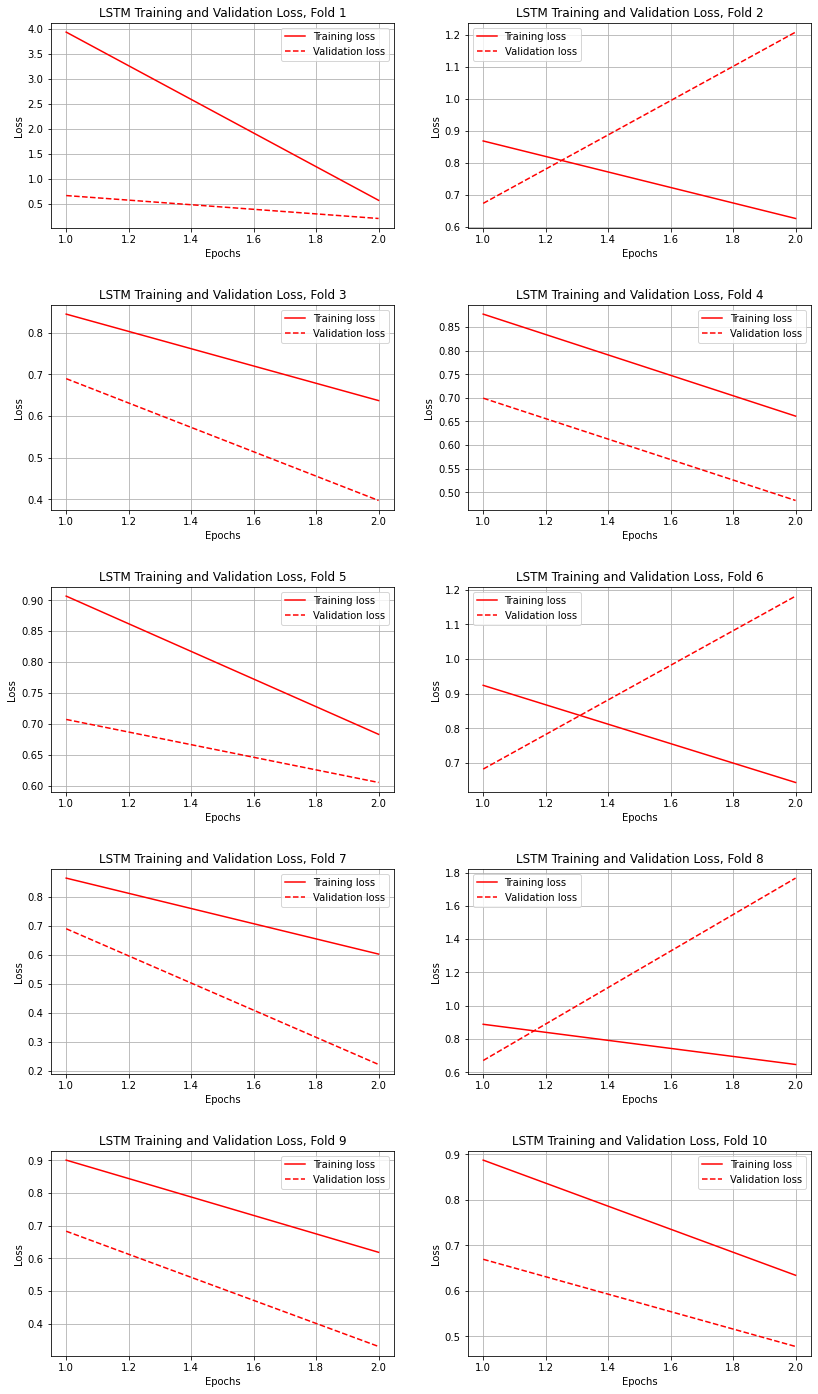

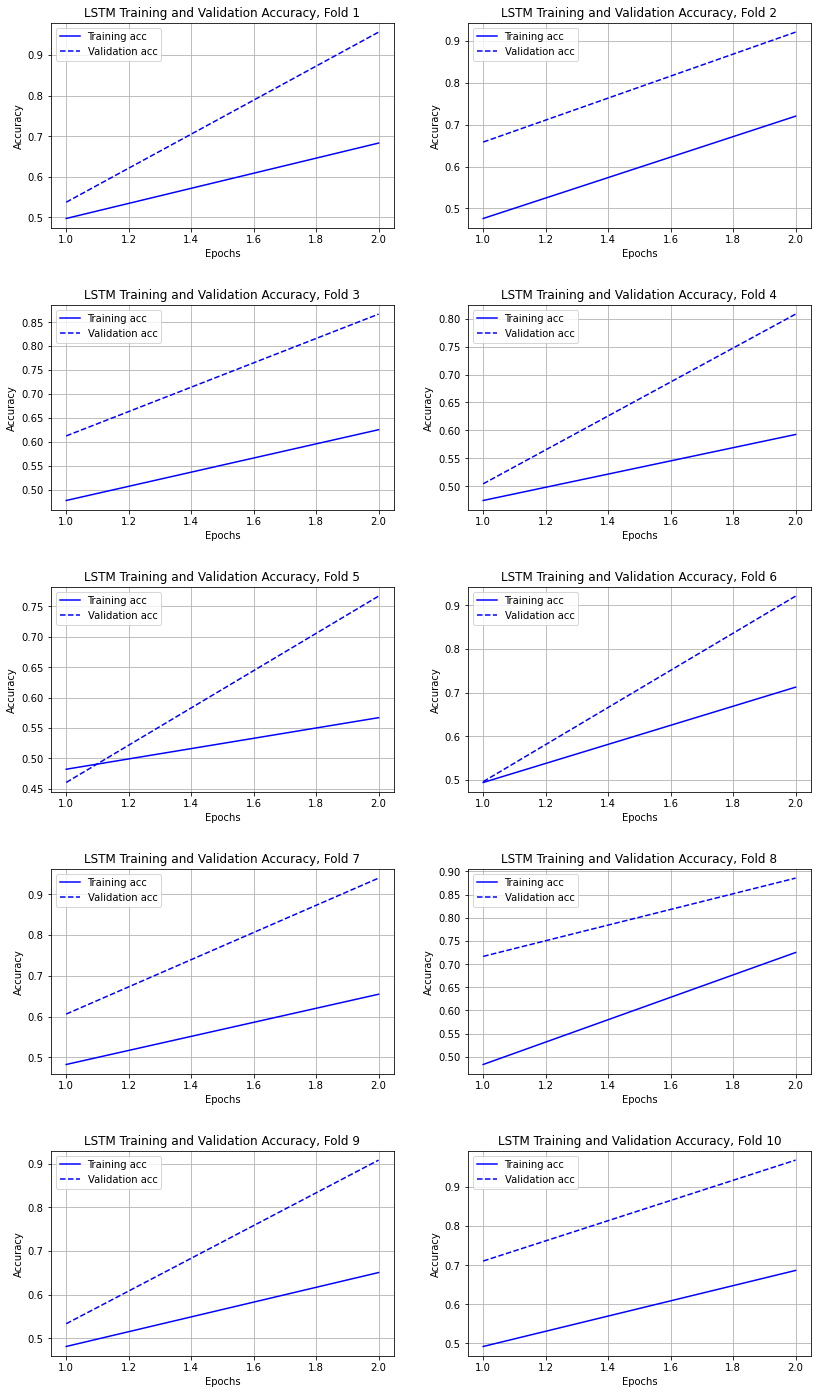

In [51]:
acc = []
val_acc = []
loss = []
val_loss = []

for i in range(len(results_history)):
  # history_dict = results_history[i].history
    history_dict = results_history[i]
  
  # print(history_dict.keys())

    acc.append(history_dict['accuracy'])
    val_acc.append(history_dict['val_accuracy'])
    loss.append(history_dict['loss'])
    val_loss.append(history_dict['val_loss'])
  
    ##loss plot
epochs = range(1, len(acc[0]) + 1)
fig_row = -(-(len(acc)) // 2)
fig_col = 2
plt.rcParams['figure.figsize'] = [12, 20]
for i in range(len(loss)):
    plt.subplot(fig_row, fig_col, i+1)
    plt.plot(epochs, loss[i], 'r', label='Training loss')
    plt.plot(epochs, val_loss[i], 'r--', label='Validation loss')
    plt.title('LSTM Training and Validation Loss, Fold {}'.format(i+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
  # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # plt.minorticks_on()
plt.tight_layout(pad=3.0)
plt.savefig("D:/JupyterNotebook/Source Code TA/model_save/lstm_loss_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


# # Accuracy Plot
plt.clf()   # clear figure
for i in range(len(acc)):
    plt.subplot(fig_row, fig_col, i+1)
    plt.plot(epochs, acc[i], 'b', label='Training acc')
    plt.plot(epochs, val_acc[i], 'b--', label='Validation acc')
    plt.title('LSTM Training and Validation Accuracy, Fold {}'.format(i+1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig("D:/JupyterNotebook/Source Code TA/model_save/lstm_accuracy_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()

In [52]:
idx_best = 0
best_acc = 0

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Metrics Score per fold')
for i in range(0, len(all_accuracy)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}')
    print('Accuracy: %f' % all_accuracy[i])
    print('Precision: %f' % all_precision[i])
    print('Recall: %f' % all_recall[i])
    print('F1 score: %f' % all_f1[i])
    if (all_accuracy[i] >= best_acc):
        idx_best = i
        best_acc = all_accuracy[i]
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Accuracy: {np.mean(np.asarray(all_accuracy))}')
print(f'> Average Precision: {np.mean(np.asarray(all_precision))}')
print(f'> Average Recall: {np.mean(np.asarray(all_recall))}')
print(f'> Average F1 Score: {np.mean(np.asarray(all_f1))}')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Metrics Score per fold
------------------------------------------------------------------------
> Fold 1
Accuracy: 0.956250
Precision: 0.938865
Recall: 0.968468
F1 score: 0.953437
------------------------------------------------------------------------
> Fold 2
Accuracy: 0.920833
Precision: 0.870588
Recall: 0.977974
F1 score: 0.921162
------------------------------------------------------------------------
> Fold 3
Accuracy: 0.866667
Precision: 0.929907
Recall: 0.802419
F1 score: 0.861472
------------------------------------------------------------------------
> Fold 4
Accuracy: 0.808333
Precision: 0.721683
Recall: 0.973799
F1 score: 0.828996
------------------------------------------------------------------------
> Fold 5
Accuracy: 0.766667
Precision: 0.687500
Recall: 0.991803
F1 score: 0.812081
------------------------------------------------------------------------
> Fold 6
Accuracy: 0.920833
Precision: 0.97368

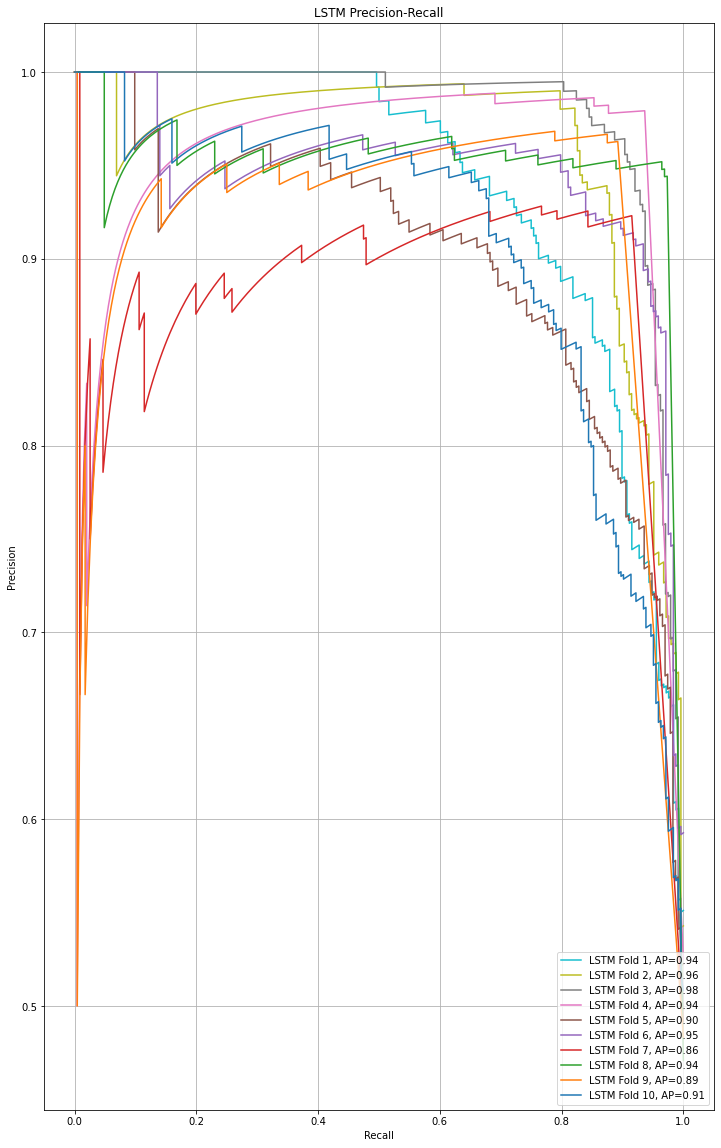

In [39]:
import matplotlib.cm as cm

colors = cm.tab10_r(np.linspace(0, 1, len(all_arr_recall)))


plt.clf()   # clear figure
plt.rcParams['figure.figsize'] = [5, 8]

for i in range(len(all_arr_recall)):
    plt.plot(all_arr_recall[i], all_arr_precision[i], color=colors[i], label='LSTM Fold {}, AP={:0.2f}'.format(i+1, all_ave_precision[i]))
  # plt.plot(np.linspace(0, 1, thresholds[i].size), thresholds[i], linestyle='--', label='Threshold')
plt.title('LSTM Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=4)
plt.grid(True)
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.minorticks_on()
plt.savefig("D:/JupyterNotebook/Source Code TA/model_save/lstm_10fold_precision_recall.png", format='png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

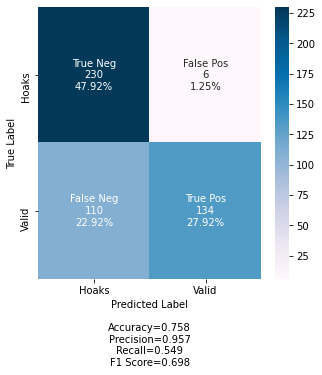

In [49]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [5, 5]
for j in range(len(all_cf_matrices)):
    cf_matrix_best = all_cf_matrices[j]

    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        all_accuracy[j],all_precision[j],all_recall[j],all_f1[j])

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix_best.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_best.flatten()/np.sum(cf_matrix_best)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
            
    labels = np.asarray(labels).reshape(2,2)
    categories = ['Hoaks', 'Valid']
  # cmap = sns.dark_palette("red")
  # cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
  # cmap = sns.color_palette("GnBu_d")

    plt.clf() 
    plt.figure()
    svm = sns.heatmap(cf_matrix_best, annot=labels, fmt='', cmap='PuBu',xticklabels=categories,yticklabels=categories)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label' + stats_text)

  # figure = svm.get_figure()    
  # figure.savefig('./lstm/lstm_conf_matrix.png', dpi=150)

    plt.savefig("D:/JupyterNotebook/Source Code TA/model_save/lstm_best_10fold_conf_matrix_fold{}.png".format(j+1), format='png', dpi=150, bbox_inches='tight')